In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from torchvision import datasets, transforms

In [2]:
# load dataset 
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [3]:
# visualize torch vector and sample prediction

import matplotlib.pyplot as plt
import numpy as np

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

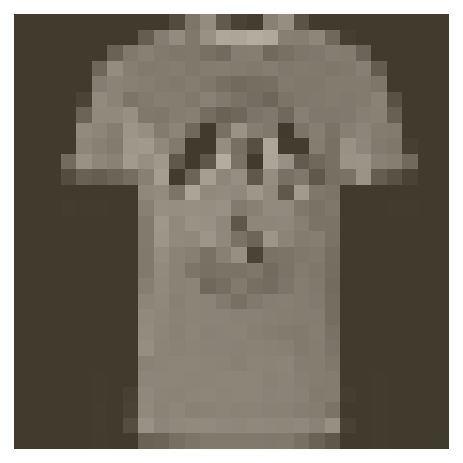

In [4]:
image, label = next(iter(trainloader))
imshow(image[0,:]);

In [5]:
class Fashion(nn.Module):
    
    # Defining the layers, 128, 64, 10 units each
    def __init__(self):
        super(Fashion, self).__init__()
        self.fc1 = nn.Linear(784, 600)
        self.bn1 = nn.BatchNorm1d(600) # Batcn Norm for the first layer
        self.fc2 = nn.Linear(600, 400)
        self.bn2 = nn.BatchNorm1d(400) # Batcn Norm for the secon layer
        self.fc3 = nn.Linear(400, 100)
        self.bn3 = nn.BatchNorm1d(100)  # Batcn Norm for the third layer
        self.out = nn.Linear(100, 10)
        self.do  = nn.Dropout(0.2, inplace=True)
        
    # Forward pass through the network, returns the output logits
    def forward(self, x):
        x = F.relu(self.bn1(self.do(self.fc1(x))))
        x = F.relu(self.bn2(self.do(self.fc2(x))))
        x = F.relu(self.bn3(self.do(self.fc3(x))))
        return self.out(x)

model = Fashion()
model

Fashion(
  (fc1): Linear(in_features=784, out_features=600, bias=True)
  (bn1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=600, out_features=400, bias=True)
  (bn2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=400, out_features=100, bias=True)
  (bn3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=100, out_features=10, bias=True)
  (do): Dropout(p=0.2, inplace=True)
)

In [6]:
optimizer = optim.Adam(model.parameters(), lr=0.003)
criterion = nn.NLLLoss()

In [9]:
epochs = 5
#print_every = 40
train_losses = []
test_losses = []
#accuracies = []

for epoch in range(epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(iter(trainloader)):
        images.resize_(images.size()[0], 784)
    
        optimizer.zero_grad()   # 1st step: reset the gradients

        logits = model.forward(images) #2nd step: make the prediction
        output = F.log_softmax(logits, dim=1)

        train_loss = criterion(output, labels)   #3rd step: compute the loss

        train_loss.backward() #4th step: backward pass

        optimizer.step() #5th step: save the weights
        running_loss += train_loss.item()


    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(iter(testloader)):
            images.resize_(images.size()[0], 784)
            logits = model.forward(images)
            output = F.log_softmax(logits, dim=1)

            test_loss = criterion(output, labels)

                #classes = output > 0.5

                #acc = sum(classes == labels) / classes.shape[0]

    model.train()

    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    #accuracies.append(acc)
    print(f'Epoch: {epoch + 1} | loss: {train_loss.item()} | test loss: {test_loss.item()}') #| accuracy: {acc}')

Epoch: 1 | loss: 0.13171911239624023 | test loss: 0.2249264419078827
Epoch: 2 | loss: 0.10949113219976425 | test loss: 0.3168235123157501
Epoch: 3 | loss: 0.27129924297332764 | test loss: 0.283514142036438
Epoch: 4 | loss: 0.26288485527038574 | test loss: 1.0000330209732056
Epoch: 5 | loss: 0.2900851368904114 | test loss: 0.3553297519683838


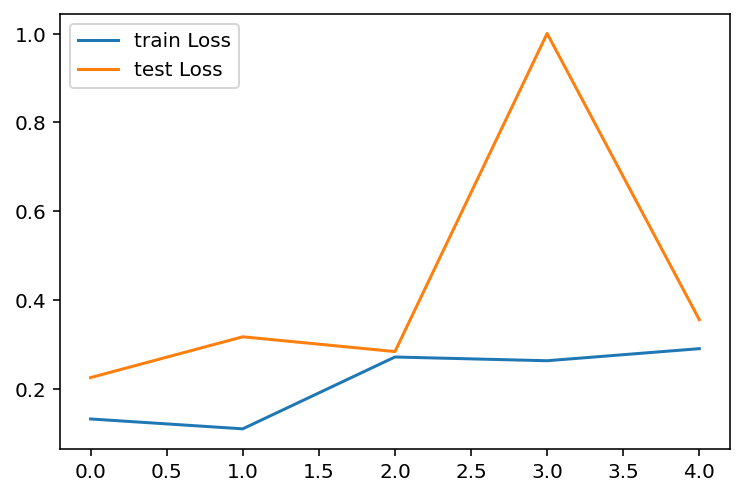

In [10]:
plt.plot(train_losses, label='train Loss')
plt.plot(test_losses, label='test Loss')
#plt.plot(accuracies, label='accuracy')
plt.legend()
plt.show()

In [ ]:
# check predicts well using view classify

images, labels = next(iter(testloader))
images.resize_(images.shape[0], 1, 784)
logit = model.forward(images[0,:])
ps = F.softmax(logit, dim =1)
print(ps)
view_classify(images[0].view(1, 28, 28), ps)

In [ ]:
# tips for validation
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

In [ ]:
equals = top_class == labels.view(*top_class.shape)

In [ ]:
misclassified = [index for index,value in enumerate(equals) if value.item() is False] 

In [ ]:
# compute accuracy

accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

In [ ]:
# save and load model
torch.save(model.state_dict(), 'checkpoint.pth')

In [ ]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

In [ ]:
model.load_state_dict(state_dict)